In [1]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [4]:
x_train , x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)
x_val = x_val.astype('float32')

In [5]:
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))
print(len(x_val))
print(len(y_val))

40000
40000
10000
10000
10000
10000


In [6]:
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))

x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)
x_val = (x_val-mean)/(std+1e-7)


In [7]:
num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)
y_val = np_utils.to_categorical(y_val,num_classes)

In [8]:
weight_decay = 1e-4

In [9]:
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
__________

In [10]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))
print(len(x_val))
print(len(y_val))
    horizontal_flip=True,
    )
datagen.fit(x_train)

In [11]:
from keras.callbacks import ModelCheckpoint, TensorBoard, CSVLogger,ReduceLROnPlateau,LearningRateScheduler,EarlyStopping
mc = ModelCheckpoint('Ciphar_Adam_elu.h5', monitor='val_loss', save_best_only=True)
tb = TensorBoard(log_dir='./logs', write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, update_freq='epoch')
cv = CSVLogger('Ciphar_Adam_elu.csv',append=True)
rp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
#es = EarlyStopping(monitor='val_loss', min_delta=0, patience=25, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

In [12]:
batch_size = 64

opt_rms = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True) 

model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])

history=model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=200,validation_data=(x_val,y_val),
                    class_weight='auto',verbose=1,callbacks=[LearningRateScheduler(lr_schedule),mc,cv,tb,rp])

Epoch 1/200
625/625 [==============================] - 16s 26ms/step - loss: 1.9301 - acc: 0.4032 - val_loss: 1.4551 - val_acc: 0.5420
Epoch 2/200
625/625 [==============================] - 15s 24ms/step - loss: 1.3560 - acc: 0.5484 - val_loss: 1.0565 - val_acc: 0.6507
Epoch 3/200
625/625 [==============================] - 15s 24ms/step - loss: 1.1347 - acc: 0.6233 - val_loss: 1.0837 - val_acc: 0.6520
Epoch 4/200
625/625 [==============================] - 15s 25ms/step - loss: 1.0066 - acc: 0.6646 - val_loss: 0.9798 - val_acc: 0.6841
Epoch 5/200
625/625 [==============================] - 15s 24ms/step - loss: 0.9425 - acc: 0.6904 - val_loss: 0.8590 - val_acc: 0.7272
Epoch 6/200
625/625 [==============================] - 15s 24ms/step - loss: 0.8770 - acc: 0.7133 - val_loss: 0.7196 - val_acc: 0.7707
Epoch 7/200
625/625 [==============================] - 15s 24ms/step - loss: 0.8336 - acc: 0.7310 - val_loss: 0.7764 - val_acc: 0.7615
Epoch 8/200
625/625 [==============================] - 

625/625 [==============================] - 15s 24ms/step - loss: 0.3747 - acc: 0.9033 - val_loss: 0.4555 - val_acc: 0.8841
Epoch 122/200
625/625 [==============================] - 15s 23ms/step - loss: 0.3748 - acc: 0.9034 - val_loss: 0.4406 - val_acc: 0.8911
Epoch 123/200
625/625 [==============================] - 14s 23ms/step - loss: 0.3695 - acc: 0.9049 - val_loss: 0.4384 - val_acc: 0.8929
Epoch 124/200
625/625 [==============================] - 15s 24ms/step - loss: 0.3691 - acc: 0.9050 - val_loss: 0.4247 - val_acc: 0.8956
Epoch 125/200
625/625 [==============================] - 15s 24ms/step - loss: 0.3697 - acc: 0.9049 - val_loss: 0.4299 - val_acc: 0.8929
Epoch 126/200
625/625 [==============================] - 15s 24ms/step - loss: 0.3676 - acc: 0.9044 - val_loss: 0.4622 - val_acc: 0.8866
Epoch 127/200
625/625 [==============================] - 15s 24ms/step - loss: 0.3644 - acc: 0.9062 - val_loss: 0.4539 - val_acc: 0.8880
Epoch 128/200
625/625 [==============================] 

Epoch 181/200
625/625 [==============================] - 15s 24ms/step - loss: 0.3513 - acc: 0.9090 - val_loss: 0.4557 - val_acc: 0.8868
Epoch 182/200
625/625 [==============================] - 15s 24ms/step - loss: 0.3541 - acc: 0.9060 - val_loss: 0.4198 - val_acc: 0.8965
Epoch 183/200
625/625 [==============================] - 15s 24ms/step - loss: 0.3482 - acc: 0.9092 - val_loss: 0.4251 - val_acc: 0.8939
Epoch 184/200
625/625 [==============================] - 15s 23ms/step - loss: 0.3453 - acc: 0.9077 - val_loss: 0.4392 - val_acc: 0.8918
Epoch 185/200
625/625 [==============================] - 15s 24ms/step - loss: 0.3513 - acc: 0.9076 - val_loss: 0.4325 - val_acc: 0.8942
Epoch 186/200
625/625 [==============================] - 14s 23ms/step - loss: 0.3469 - acc: 0.9091 - val_loss: 0.4455 - val_acc: 0.8900
Epoch 187/200
625/625 [==============================] - 15s 24ms/step - loss: 0.3460 - acc: 0.9091 - val_loss: 0.4450 - val_acc: 0.8896
Epoch 188/200
625/625 [==================

In [13]:
test_loss,test_acc=model.evaluate(x_test,y_test)
print(test_loss)
print(test_acc)

10000/10000 [==============================] - 1s 147us/step
0.44303976254463195
0.8905


In [15]:
train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']
xc=range(200)

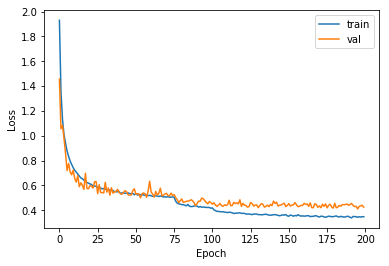

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train','val'])

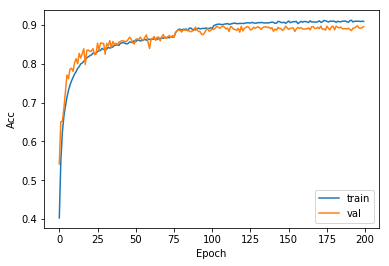

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend(['train','val'])

In [18]:
pred=model.predict(x_test[0].reshape(1,32,32,3))
print(pred)
print(pred.argmax())

[[6.8175274e-07 1.0575599e-04 1.1933742e-05 9.9811918e-01 6.9215923e-07
  3.2910411e-04 1.4180160e-03 2.6161516e-07 1.3233747e-05 1.0306467e-06]]
3


In [19]:
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
import itertools

Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)
target_names = ['class 0', 'class 1', 'class 2','class 3','class 4','class 5','class 6','class 7','class 8','class 9']
print(classification_report(np.argmax(y_test,axis=1), y_pred,target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.93      0.88      0.90      1000
     class 1       0.91      0.97      0.94      1000
     class 2       0.89      0.84      0.86      1000
     class 3       0.87      0.71      0.78      1000
     class 4       0.85      0.92      0.88      1000
     class 5       0.87      0.83      0.85      1000
     class 6       0.87      0.96      0.91      1000
     class 7       0.90      0.93      0.92      1000
     class 8       0.93      0.94      0.94      1000
     class 9       0.89      0.94      0.91      1000

   micro avg       0.89      0.89      0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [20]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    acc=np.trace(cm)/float(np.sum(cm))
    miss_class=1-acc
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    print(acc)
    print(miss_class)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[878  12  30   2  12   1   9   3  35  18]
 [  2 969   0   0   0   0   0   0   4  25]
 [ 17   3 840  19  32  23  43  13   4   6]
 [ 11  14  24 708  47  89  51  26  12  18]
 [  5   1  15   9 917   3  22  25   1   2]
 [  3   5  14  60  29 827  16  30   2  14]
 [  3   2  10   9   7   2 962   0   2   3]
 [  6   1  10   7  28  10   4 926   1   7]
 [ 17  12   3   1   1   0   5   0 938  23]
 [  4  44   2   2   0   0   0   1   7 940]]
0.8905
0.10950000000000004


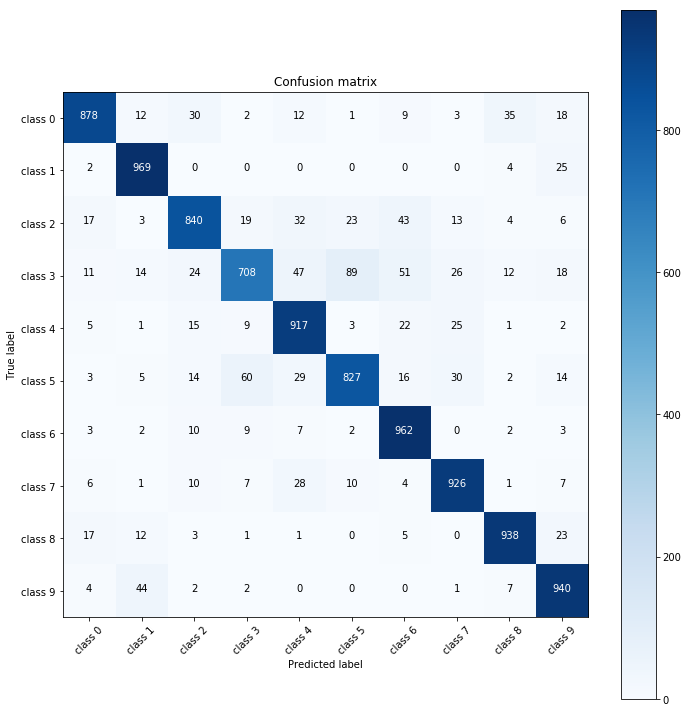

In [21]:
cnf_matrix = (confusion_matrix(np.argmax(y_test,axis=1), y_pred))
np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix')